In [1]:
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import spearmanr
import seaborn as sns
import pandas as pd
from matplotlib.ticker import Locator
sns.set_style("white")

# from https://stackoverflow.com/questions/20470892/how-to-place-minor-ticks-on-symlog-scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            if majorlocs[i] <= self.linthresh:
                continue
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

Human (chr22) Illumina [40, 0, 0, 0, 0, 0, 0] [2006, 2006, 2006, 2006, 2006, 2006, 2006] [0.014242115971515769, 1.3594217347956132, 0.01794616151545364, 0.0, 0.22083748753738783, 0.01794616151545364, 0.0009970089730807576]
Human (chr22) PacBio CLR [0, 0, 0, 0, 0, 0, 0] [204, 204, 0, 204, 204, 204, 204] [6.504901960784314, 228.7549019607843, nan, 8901.446078431372, 13.632352941176471, 3213.950980392157, 13.823529411764707]


/tmp/ipykernel_480808/4056399941.py:123: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,axis='both', which='both')
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_480808/4056399941.py:123: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,axis='both', which='both')


E. coli (NC_000913.3) Illumina [0, 0, 0, 0, 0, 0, 0] [2560, 2560, 2560, 2560, 2560, 2560, 2560] [0.019140625, 0.068359375, 0.0015625, 0.0, 0.131640625, 0.0, 0.0]
E. coli (NC_000913.3) PacBio CLR [0, 0, 0, 0, 0, 0, 0] [199, 199, 0, 199, 199, 199, 199] [6.849246231155779, 52.90954773869347, nan, 9322.96984924623, 1.6130653266331658, 47.89949748743719, 2.020100502512563]


/tmp/ipykernel_480808/4056399941.py:123: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,axis='both', which='both')
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_480808/4056399941.py:123: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True,axis='both', which='both')


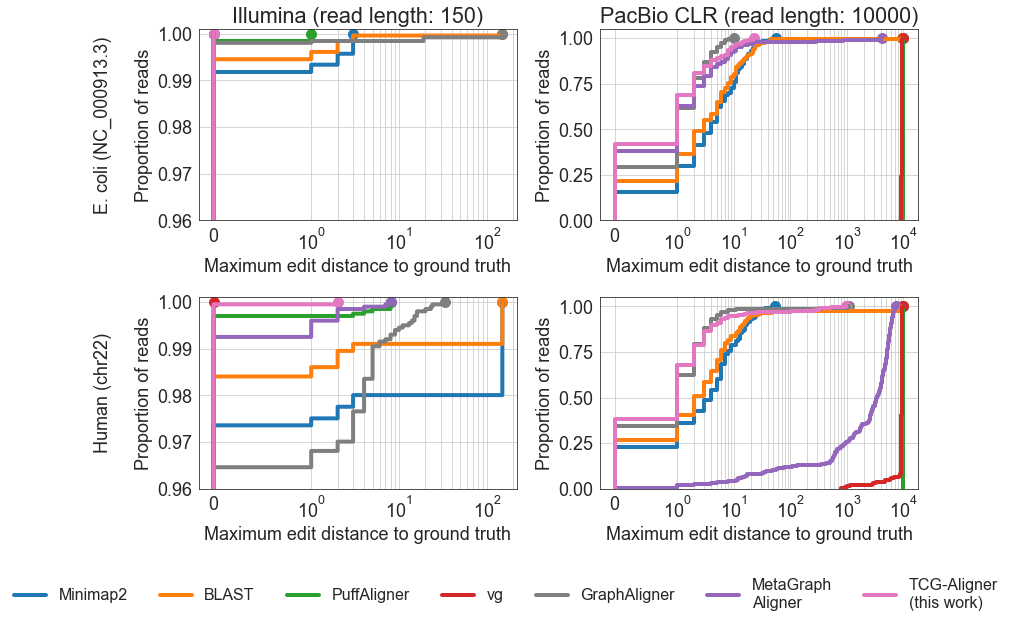

In [29]:
# set this to True to set a zero penalty for indels at alignment ends
# for some alignment applications, this is the default
local_align = False

# use for local alignment score
def score_cigar(cigar):
    match = 0
    mismatch = 1
    gap_open = 1
    gap_ext = 1
    cur_num = 0
    score = 0
    num_ops = 0
    for i, c in enumerate(cigar):
        if c.isnumeric():
            cur_num = cur_num * 10 + int(c)
        else:
            if c == "=":
                score += cur_num * match
            elif c == "X":
                score += cur_num * mismatch
            elif (c == "D" or c == "I") and num_ops > 0 and i + 1 != len(cigar):
                score += gap_open + (cur_num - 1) * gap_ext
            cur_num = 0
            num_ops += 1
    return score

plt.rcParams.update({'font.size': 18})
data_types = [
    ("Illumina", "illumina", 150),
    ("PacBio CLR","pacbio", 10000),
]
program = [
    ("Minimap2", "minimap2.sam", "#b2182b"),
    ("BLAST", "blast.out", "#ef8a62"),
    ("PuffAligner", "pufferfish.sam", "#fddbc7"),
    ("vg", "vg.sam", "#d1e5f0"),    
    ("GraphAligner", "graphaligner.gaf","green"),
    ("MetaGraph\nAligner", "metagraph_base.out", "#67a9cf"),
    ("TCG-Aligner\n(this work)", "metagraph_coord.out", "#2166ac"),    
]
experiments = [
    ("Human (chr22)", "hg38/chr22"),
    ("E. coli (NC_000913.3)","NC_000913.3/NC_000913.3"),
]

base_size=4
alpha=0.2

fig,all_axs = plt.subplots(len(experiments),
                           len(data_types),
                           figsize=(1.5*base_size*len(data_types), base_size*len(experiments)))
cm=plt.cm.get_cmap('tab10')
for idx, ((exp_title,exp_path),axs) in enumerate(zip(experiments,all_axs[::-1])):
    for jdx, ((read_name,read_prefix,read_length),ax) in enumerate(zip(data_types,axs)):
        prog_scores = []
        num_unmapped = []
        num_reads = []
        for prog_name,prog_prefix,linestyle in program:
            infile = "{}.sim.{}.{}.results.sam".format(exp_path,read_prefix,prog_prefix)            
            with open(infile, 'r') as f:
                unmapped = 0
                nreads = 0
                lines = (line.rstrip().split("\t") for line in f if line[0] != '@')
                scores = []
                for l1,l2 in itertools.zip_longest(*[lines]*2):
                    nreads += 1                    
                    s1_sp = l1[-1].split(":")
                    if s1_sp[0] == "NM":
                        if local_align:
                            c1 = l1[5]
                            s1 = score_cigar(c1)
                        else:
                            s1 = int(s1_sp[-1])
                    else:
                        assert(s1_sp[0] == "*")
                        s1 = np.inf
                    s2_sp = l2[-1].split(":")
                    if s2_sp[0] == "NM":
                        if local_align:
                            c2 = l2[5]
                            s2 = score_cigar(c2)
                        else:
                            s2 = int(s2_sp[-1])
                    else:
                        assert(s2_sp[0] == "*")
                        s2 = np.inf
                        
                    score = min(s1,s2)
                    if score == np.inf:
                        score = read_length
                        unmapped += 1
                        continue
                    scores.append(score)
                num_unmapped.append(unmapped)
                num_reads.append(nreads)
                prog_scores.append(np.array(scores))
        print(exp_title,read_name,num_unmapped,num_reads, [np.mean(a) for a in prog_scores])
        
        labels = [a[0] for a in program]
        styles = [a[2] for a in program]
        df = pd.concat([pd.DataFrame(data={a:b}) for a,b in zip(labels, prog_scores)], ignore_index=True, axis=1)
        df.fillna(read_length,inplace=True)
        df.columns = labels
#         sns.boxplot(data=df,ax=ax)
#         for patch in ax.artists:
#             r, g, b, a = patch.get_facecolor()
#             patch.set_facecolor((r, g, b, alpha))
#         sns.stripplot(data=df,ax=ax,alpha=alpha)
#         sns.ecdfplot(data=df,ax=ax,linewidth=4,palette='Set1')
        for kdx,(label,linestyle) in enumerate(zip(labels,styles)):
            #color = list(cm(kdx if kdx != 5 else kdx + 5))
            color = list(cm(kdx if kdx < 4 else (7 if kdx == 4 else 4 if kdx == 5 else 6)))
            sns.ecdfplot(data=df[label],ax=ax,linewidth=4,label=label if idx == 0 and jdx == 0 else None,
                         #linestyle=["-",":"][kdx % 2],
#                          color=cm.colors[kdx]
                         color=color
                         #cmap="Set1",
                        )
            ax.scatter(x=df[label].max(),y=[1],color=color,s=10**2)
        ax.set_xscale("symlog",linthresh=1)
        ax.xaxis.set_minor_locator(MinorSymLogLocator(1))
        ax.grid(b=True,axis='both', which='both')
        #ax.set_yscale("symlog",linthresh=0.01)
        #ax.set_ylim([-0.1,ax.get_ylim()[1]])
        
        #ax.grid(which="both",axis="y")
        #ax.set_title("{} (read length: {})".format(read_name,read_length))
        #ax.set_ylabel("Edit distance to ground truth")
        if idx != 0:
            ax.set_title("{} (read length: {})".format(read_name, read_length))
        ax.set_xlabel("Maximum edit distance to ground truth")
        #ax.set_yscale("symlog",linthres=0.01)
        #ax.legend(loc='best')
        
        ax.set_ylabel("Proportion of reads")
        
        if jdx == 0:
            ax.set_ylabel("\n\n".join([exp_title, ax.get_ylabel()]))
    
plt.tick_params(axis='y', which='both')
#fig.legend(loc='upper right',bbox_to_anchor=(1.2, 0.95))
fig.legend(loc="upper center", ncol=len(program),bbox_to_anchor=(0.5, 0),fontsize=16,edgecolor='w')
#all_axs[0][0].set_visible(False)
#all_axs[0][1].set_visible(False)
#all_axs[0][0].set_ylim([0.99, 1.0005])
all_axs[0][0].set_ylim([0.96, 1.001])
all_axs[1][0].set_ylim([0.96, 1.001])
#all_axs[1][0].set_ylim([0.97, 1.001])
all_axs[0][1].set_ylim([0, 1.05])
all_axs[1][1].set_ylim([0, 1.05])
#all_axs[0][0].set_yscale("symlog",linthresh=0.9)
#all_axs[1][0].set_yscale("symlog",linthresh=0.9)
fig.tight_layout()
fig.savefig("alignment_accuracy.pdf",bbox_inches='tight')
fig.savefig("Karasikov_Fig4.pdf",bbox_inches='tight')